#Steps

Ignore commented code

1) Put your images in a folder and enter that folder location in instance_data_dir in section train and in the section visualize before training

2) once training is over, go to output dir created and download the lora-weights

3) Upload these weights to huggingface after signing up and creating a new account. You guys can use any name. My repo is [here](https://huggingface.co/RajSang/raj_sdxl_1000_no_prior)

4) Run inference code snippets once you have completed the above steps. Change checkpoints wherever necessary. Restart kernel as directed after running the first cell in the inference section

#Installations

In [1]:
# Install dependencies.
!pip install transformers accelerate -q
!pip install bitsandbytes>=0.40.0
!pip install -U xformers --index-url https://download.pytorch.org/whl/cu118


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 6.0 MB/s eta 0:00:00
Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00


In [3]:
!pip install git+https://github.com/huggingface/diffusers.git -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [4]:
!wget https://raw.githubusercontent.com/rajlm10/dreambooth_lora_merging/main/dream_booth.py

--2023-12-05 06:47:15--  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/dreambooth/train_dreambooth_lora_sdxl.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73581 (72K) [text/plain]
Saving to: ‘train_dreambooth_lora_sdxl.py’

train_dreambooth_lo 100%[===================>]  71.86K  --.-KB/s    in 0.007s  

2023-12-05 06:47:15 (9.41 MB/s) - ‘train_dreambooth_lora_sdxl.py’ saved [73581/73581]



In [28]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [ ]:
!unzip /content/prior.zip

#Visualize before training

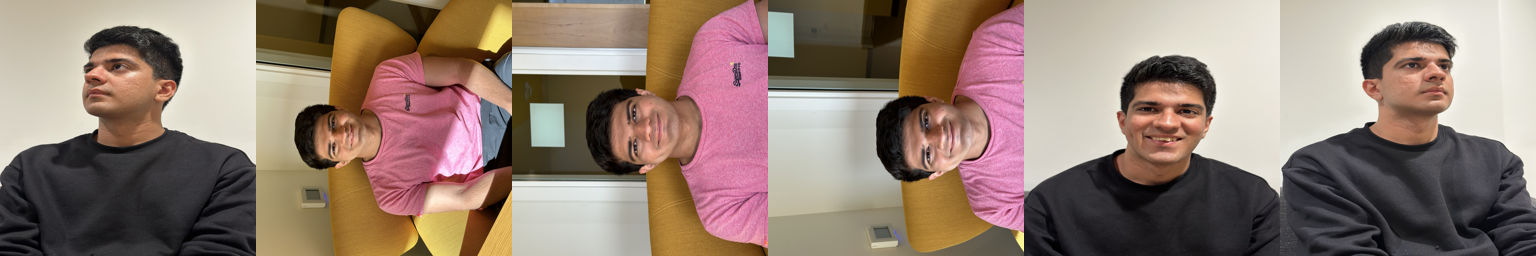

In [6]:
import glob

imgs = [Image.open(path) for path in glob.glob("./raj/*.jpeg")]
image_grid(imgs, 1, 6)

#Train

In [8]:
#!accelerate config
!accelerate config default


accelerate configuration saved at /root/.cache/huggingface/accelerate/default_config.yaml


In [9]:
import os

os.listdir('./raj'),len(os.listdir('./results'))

(['IMG_9129.jpeg',
  'IMG_9607.jpeg',
  'IMG_9611.jpeg',
  'IMG_9616.jpeg',
  'IMG_9126.jpeg',
  'IMG_9130.jpeg'],
 197)

##Without Prior Preservation

In [ ]:
#!/usr/bin/env bash
!accelerate launch dream_booth.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --instance_data_dir="raj" \
  --output_dir="sdxl-raj-1000-no-prior" \
  --mixed_precision="fp16" \
  --instance_prompt="a photo of rraj person" \
  --resolution=1024 \
  --train_batch_size=2 \
  --gradient_accumulation_steps=2 \
  --gradient_checkpointing \
  --learning_rate=6e-5 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --use_8bit_adam \
  --max_train_steps=1000


##With Prior Preservation

In [11]:
#!/usr/bin/env bash
!accelerate launch dream_booth.py \
  --pretrained_model_name_or_path="stabilityai/stable-diffusion-xl-base-1.0" \
  --pretrained_vae_model_name_or_path="madebyollin/sdxl-vae-fp16-fix" \
  --instance_data_dir="raj" \
  --class_data_dir="results" \
  --output_dir="sdxl-raj-1000" \
  --mixed_precision="fp16" \
  --instance_prompt="a photo of rraj person" \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=2 \
  --gradient_checkpointing \
  --learning_rate=6e-5 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --use_8bit_adam \
  --max_train_steps=1000\
  --with_prior_preservation --prior_loss_weight=1.0\
  --class_prompt="a photo of person"\
  --num_class_images=197

2023-12-05 06:49:17.896130: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-05 06:49:17.896192: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-05 06:49:17.896242: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-05 06:49:19.033003: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
12/05/2023 06:49:20 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

tokenizer/tokenizer_config.json: 100% 737/737 [00:00<00:00, 2.99MB/s]
t

In [12]:
import gc
import torch

def flush():
  gc.collect()
  torch.cuda.empty_cache()
  torch.cuda.reset_peak_memory_stats()

flush()